# 1. Create the Database and Proper Schema

In [2]:
##Create one database with three tables


import sqlite3
db = sqlite3.connect('alien-life.db')
cursor = db.cursor()

cursor.execute("PRAGMA foreign_keys = 1")

cross_ref_table = """CREATE TABLE CROSS_REF_TABLE( 
            patient_id      INTEGER PRIMARY KEY AUTOINCREMENT, 
            patient_age     FLOAT
);"""

cursor.execute(cross_ref_table)
db.commit()

boran_table = """CREATE TABLE BORAN_TABLE(
            patient_id      INTEGER NOT NULL,
            blood_pressure  FLOAT,
            exercise        FLOAT,
            weight          FLOAT,
            glucose         FLOAT,
            bmi             FLOAT,
            planet_id       INTEGER,
            FOREIGN KEY(patient_id) REFERENCES cross_ref_table(patient_id)
);"""

cursor.execute(boran_table)
db.commit()

radan_table = """CREATE TABLE RADAN_TABLE(
            patient_id      INTEGER NOT NULL,
            blood_pressure  FLOAT,
            exercise        FLOAT,
            weight          FLOAT,
            glucose         FLOAT,
            bmi             FLOAT,
            planet_id       INTEGER,
            FOREIGN KEY(patient_id) REFERENCES cross_ref_table(patient_id)
);"""

cursor.execute(radan_table)

db.commit()

db.close()


In [3]:
#Third, CROSS_REF_TABLE
import sqlite3
import csv

db     = sqlite3.connect('alien-life.db')
cursor = db.cursor()
cursor.execute("PRAGMA foreign_keys = 1")

with open('datasets/deidentify_list_cross_ref.csv', 'r') as f:
    
    fcsv = csv.reader(f)
    
    recs_to_load = [record for record in fcsv]
    
cursor.executemany("INSERT INTO CROSS_REF_TABLE VALUES (?, ?)", recs_to_load[1:])
                           
db.commit()
db.close()     

In [4]:
##read the csv files into the tables respectively
#First, BORAN_TABLE
import sqlite3
import csv

db     = sqlite3.connect('alien-life.db')
cursor = db.cursor()
cursor.execute("PRAGMA foreign_keys = 1")

with open('datasets/boran.csv', 'r') as f: 

    fcsv = csv.reader(f)

    recs_to_load = [record for record in fcsv]

cursor.executemany("INSERT INTO BORAN_TABLE VALUES (?, ?, ?, ?, ?, ?, ?)", recs_to_load[1:])

db.commit()
db.close()

In [5]:
#Second, RADAN_TABLE
import sqlite3
import csv
    
db     = sqlite3.connect('alien-life.db')
cursor = db.cursor()
cursor.execute("PRAGMA foreign_keys = 1")

with open('datasets/radan.csv', 'r') as f: 

    fcsv = csv.reader(f)

    recs_to_load = [record for record in fcsv]

cursor.executemany("INSERT INTO RADAN_TABLE VALUES (?, ?, ?, ?, ?, ?, ?)", recs_to_load[1:])

db.commit()
db.close()

# Check the Consisitency and Validity of the Database

In [6]:
##Here we check that the db enforces the appropriate validity checks for the boran_table
import pandas as pd
import sqlite3

db = sqlite3.connect('alien-life.db')
cursor = db.cursor()
cursor.execute("PRAGMA foreign_keys = 1")

cursor.execute("UPDATE boran_table SET patient_id = 3 WHERE exercise > 143")

db.commit()
db.close()

IntegrityError: FOREIGN KEY constraint failed

In [7]:
##Here we check that the db enforces the appropriate validity checks for the radan_table
import pandas as pd
import sqlite3

db = sqlite3.connect('alien-life.db')
cursor = db.cursor()
cursor.execute("PRAGMA foreign_keys = 1")

cursor.execute("UPDATE radan_table SET patient_id = 4569 WHERE exercise > 15")

db.commit()
db.close()

IntegrityError: FOREIGN KEY constraint failed

# Boran Linear Regression Process

In [8]:
import pandas as pd
import sqlite3

db     = sqlite3.connect('alien-life.db')


df = pd.read_sql_query("""SELECT boran_table.patient_id, boran_table.blood_pressure, cross_ref_table.patient_age, boran_table.exercise, boran_table.weight, boran_table.glucose, boran_table.bmi
        FROM boran_table 
        LEFT JOIN cross_ref_table ON boran_table.patient_id = cross_ref_table.patient_id""", db)

##there exists no null values, but in case the full data set has them we include the following
df.fillna(df.mean()).head(5)

,patient_id,blood_pressure,patient_age,exercise,weight,glucose,bmi
0,83944,199.378675,86.055427,143.205239,148.036310,125.230960,1.045336
1,41989,191.853108,76.957462,102.544295,141.588777,119.807890,0.988849
2,94365,207.226606,85.005850,36.446482,157.499291,131.750089,1.095599
3,93464,203.442508,85.762916,91.476012,152.871206,128.586136,1.071569
4,57985,194.236774,72.326139,9.071701,145.584071,122.141463,1.000579


In [9]:
cols = ['patient_age']
X_boran = df[cols]
Y_boran = df['blood_pressure']

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
model = LinearRegression()

In [12]:
model.fit(X_boran, Y_boran)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
##find the mk value
model.coef_

array([1.14074587])

In [15]:
##find the Bk value
model.intercept_

106.45741672344948

In [16]:
##test accuracy
preds = model.predict(X_boran)
preds.std()
error = preds - Y_boran

total_error = 0
for item in error:
    total_error += (item * item)
    
print('total_error: ', total_error)

mse = total_error/len(error)
print('mse: ', mse)

import numpy as np
rmse = np.sqrt(mse)
print('rmse: ', rmse)

total_error:  636.396934835724
mse:  21.213231161190798
rmse:  4.605782361465943


# Radan Linear Regression Process

In [17]:
import pandas as pd
import sqlite3

db     = sqlite3.connect('alien-life.db')


df2 = pd.read_sql_query("""SELECT radan_table.patient_id, radan_table.blood_pressure, cross_ref_table.patient_age, radan_table.exercise, radan_table.weight, radan_table.glucose, radan_table.bmi
        FROM radan_table 
        LEFT JOIN cross_ref_table ON radan_table.patient_id = cross_ref_table.patient_id""", db)

##there exists no null values, but in case the full data set has them we include the following
df2.fillna(df.mean()).head(1)

,patient_id,blood_pressure,patient_age,exercise,weight,glucose,bmi
0,83944,199.378675,86.055427,143.205239,148.03631,125.23096,1.045336


In [18]:
cols = ['patient_age']
X_radan = df2[cols]
Y_radan = df2['blood_pressure']

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
model = LinearRegression()

In [21]:
model.fit(X_radan, Y_radan)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
##find the mk value
model.coef_

array([0.47088464])

In [23]:
##find the Bk value
model.intercept_

63.825776453326256

In [24]:
##test accuracy
preds = model.predict(X_radan)
preds.std()
error = preds - Y_radan

total_error = 0
for item in error:
    total_error += (item * item)
    
print('total_error: ', total_error)

mse = total_error/len(error)
print('mse: ', mse)

import numpy as np
rmse = np.sqrt(mse)
print('rmse: ', rmse)

total_error:  216.22906224639857
mse:  7.207635408213286
rmse:  2.6847039703127953


# Generate plots for the histogram age distribution for each planet

### 1. Boran

In [25]:
import numpy as np
bages = np.asarray(X_boran)

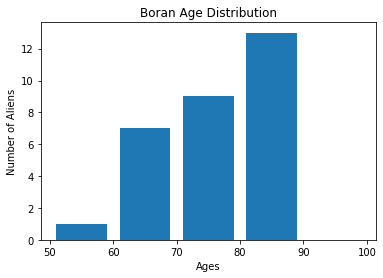

In [27]:
import matplotlib.pyplot as plt

bins = [50, 60, 70, 80, 90, 100]

plt.hist(bages, bins, histtype='bar', rwidth = 0.8)

plt.xlabel('Ages')
plt.ylabel('Number of Aliens')
plt.title('Boran Age Distribution')
plt.show()

### (a) What is the mean (average) life expectance of the creatures on Boran?

In [28]:
bages.mean()

76.41943114989894

### (b) What is the probability of a creature living past the mean life expectancy on Boran?

In [29]:
count = 0
for age in bages:
    if age > bages.mean():
        count += 1
prob = count/len(bages)
prob

0.5

### 2. Radan

In [30]:
import numpy as np
rages = np.asarray(X_radan)

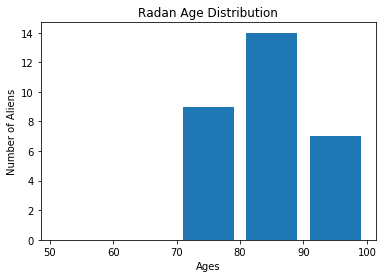

In [31]:
import matplotlib.pyplot as plt

bins = [50, 60, 70, 80, 90, 100]

plt.hist(rages, bins, histtype='bar', rwidth = 0.8)

plt.xlabel('Ages')
plt.ylabel('Number of Aliens')
plt.title('Radan Age Distribution')
plt.show()

### (a) What is the mean (average) life expectance of the creatures on Radan?

In [32]:
rages.mean()

84.21706879853835

### b) What is the probability of a creature living past the mean life expectancy on Boran?

In [33]:
count = 0
for age in rages:
    if age > rages.mean():
        count += 1
prob = count/len(rages)
prob

0.43333333333333335